In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb
os.chdir(main)
%run stdPlotting.ipynb
os.chdir(d['py'])
from gmsPython import nestingTree
from valueShares import nestedShares
from mProduction import NestedCES

The file _gams_py_gdb10.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.
The file _gams_py_gdb5.gdx is still active and was not deleted.
The file _gams_py_gdb6.gdx is still active and was not deleted.
The file _gams_py_gdb7.gdx is still active and was not deleted.
The file _gams_py_gdb8.gdx is still active and was not deleted.


# Production module

Akin to ```mProduction.ipynb```, but with high-level functions:

*Load data:*

In [2]:
t0 = 2019 # set baseline year
name = 'vA' # specify name of the CGE version we are currently working on
db = GpyDB(os.path.join(d['data'], f'{name}_{t0}')) # Load 
ws = db.ws # run everything from the same ws

## 1. Define CES value shares

### 1.1. Nesting trees

In [3]:
wasteNest = adj.rc_pd(db('nestProduction'), pd.Index(['Waste'], name = 's')) # the adj.rc_pd(s, c) adjusts the symbol 's' by matching with the condition 'c'. It operates by matching the indices.
otherNest = db('nestProduction').difference(wasteNest) 

Initialize trees:

In [4]:
waste = nestingTree.Tree('W', tree = wasteNest.to_list(), f = 'CES') 
other = nestingTree.Tree('O', tree = otherNest.to_list(), f = 'CES')
nest = nestingTree.AggTree(name = 'P', trees = {t.name: t for t  in (waste, other)}, ws = ws)
nest(namespace = {str(n)+'_input':n for n in db('n')}) # the __call__ method establishes relevant symbols to create the gams model

### 1.2. Create value shares to identify $\mu$

The next step is to identify $\mu$ parameters for the nested model. We base this on the value shares in the baseline year. For instance, if we know the value of energy and capital in baseline $vD(E), vD(K)$, a CES nest that combines the two will have $\mu_E = vD(E)/(vD(E)+vD(K))$ and $\mu_K = vD(K)/(vD(E)+vD(K))$. To do this with the more general nesting structure, we use a simple class ```nestedShares``` that ultimately writes a GAMS code and let GAMS solve it:

In [5]:
v = nestedShares(nest, ws = ws)
db_vs = v(db) # one-liner that returns solution database

Use share parameters and values to get initial values for intermediates:

In [6]:
db['mu'] = db_vs('mu').xs(t0) 
db.aom(adj.rc_pd(db_vs('vD'), nest.get('int')).rename('qD'), name = 'qD', priority = 'first') # specify intermediate goods levels

## 2. Partial Equilibirum Model

In [7]:
db.aom(db('pD_dur'), name = 'pD')
AggDB.subsetDB(db, db('s_p'))

Clean up database a bit (this is not necessary, but it removes some variables that are not ultimately used in the model):

In [8]:
[db.series.__delitem__(k) for k in ('vD','vTax', 'vD_dur','vD_depr','vD_inv', 'vS', 'pD_dur') if k in db.symbols];

For variables that are defined over $t$, but we do not yet have an initial value for all $t$, extrapolate:

*Note: This forces extrapolation of all variables defined over $t$ - if it is important that some variables are not extrapolated, they should be removed from this statement.*

In [9]:
[symbol.__setattr__('vals', extrapolateUpper(symbol.vals, db('tE')[0])) for symbol in [db[k] for k in db.varDom('t')['t']]];

Next, we can now initialize the production module using from the nesting tree, we established earlier. 

In [10]:
m = NestedCES(nest, partial = True)
m.initStuff(db = db)

Use $j$-terms solution approach for calibration:

In [11]:
soldb = m.jSolve(10, state = 'C', ϕ = .1) # solve calibration model with 10 steps and nonlinear grid (ϕ<1 means that adjustments to jTerms start large and then decrease)

Overwrite solution:

In [12]:
[m.db.__setitem__(k, soldb[k]) for k in m.db.getTypes(['var']) if k in soldb.symbols]; # use solution database
m.db.mergeInternal()
m.solve(state = 'B') # test solve of baseline

Visualize accumulation of durables over time as a rough check:

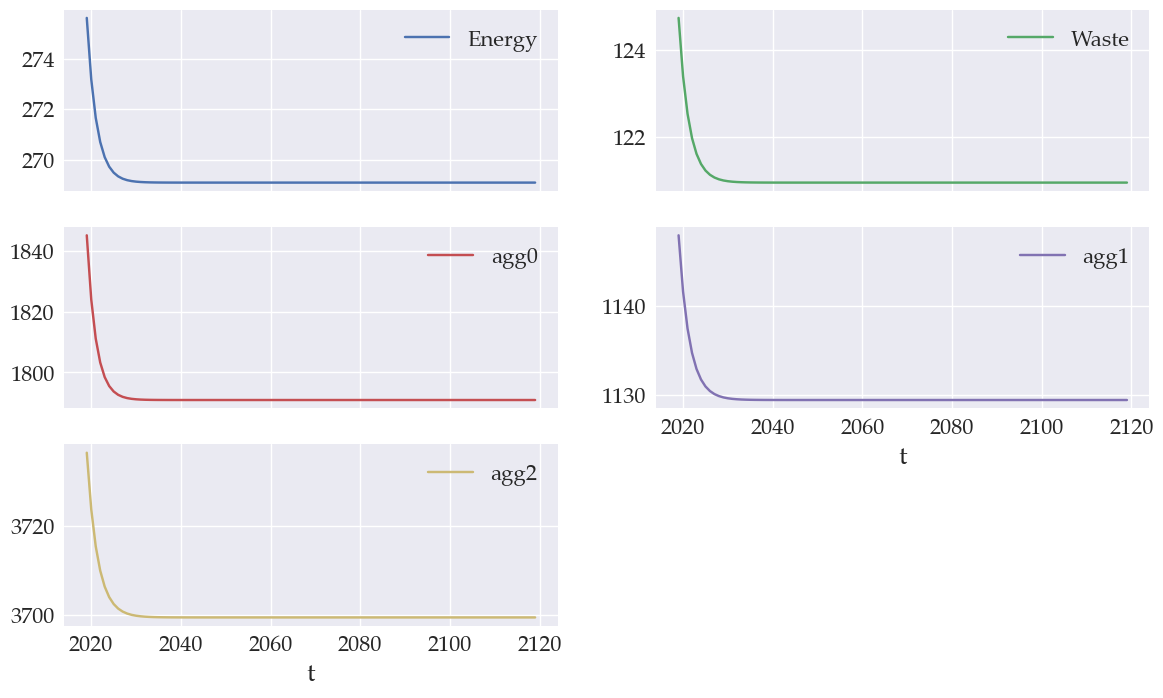

In [15]:
mult_graphs()
m.out_db('qD').xs('K',level='n').unstack('s').plot(subplots=True, layout = (3,2), figsize = (14,8));